In [1]:
from ml_collections import ConfigDict
from pathlib import Path
from utils import get_classifier, get_data_config, get_dtype, load_checkpoint, prepare_test_dataset
from dataset_utils import get_dataloader, get_dataset
from jax import random
from models.utils import sample_gaussian

model_type = 'gfz'
checkpoint_path = f"{model_type}-50-epochs-a-20"

checkpoint = load_checkpoint(Path.cwd() / "checkpoints/modified/" / checkpoint_path)

config = ConfigDict(checkpoint["config"])

dtype = get_dtype(config.dtype)
test_key = random.PRNGKey(config.attack_seed)
classifier = get_classifier(config) 

test_ds = get_dataset(config.dataset, train=False)
train_ds = get_dataset(config.dataset, train=True)
dataset_config = get_data_config(test_ds)
test_images, test_labels = prepare_test_dataset(test_ds, dataset_config, dtype)

train_images, train_labels = prepare_test_dataset(train_ds, dataset_config, dtype)

test_dl = get_dataloader(test_ds, config.test_batch_size, dtype)

model_config = classifier.create_model_config(config)
log_likelihood_fn = classifier.log_likelihood_A
loss_fn = classifier.loss_A
trained_params = checkpoint["params"]

In [2]:
from flax import linen as nn
import jax
from jax import jacrev
import numpy as np
from functools import partial
from jax.scipy.special import logsumexp
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.special import softmax

def init_data(test_key, _type='test', n_samples=10):
    if _type == 'test':
        # idx = np.random.choice(range(len(test_images)), n_samples, replace=False)
        idx = np.arange(n_samples)
        all_xs = test_images[idx]
        true_ys = test_labels[idx]

    elif _type == 'train':
        # idx = np.random.choice(range(len(train_images)), n_samples, replace=False)
        idx = np.arange(n_samples)
        all_xs = train_images[idx]
        true_ys = train_labels[idx]

    true_labels = np.argmax(true_ys, axis=1)

    # K = model_config.K
    K = 1
    batch_size = n_samples
    test_key, epsilons = sample_gaussian(test_key, (batch_size, model_config.n_classes * K, model_config.d_latent))
    epsilons = epsilons[:n_samples*model_config.n_classes]
    all_ys = nn.one_hot(jnp.repeat(jnp.arange(model_config.n_classes), K), model_config.n_classes, dtype=dtype)
    
    return all_xs, true_labels, epsilons, all_ys, K, test_key

def get_model_output(x, epsilon, y, K):
    outputs = jax.vmap(
            partial(classifier.classifier(model_config).apply, {'params': trained_params}, train=False),
            in_axes=(None, 0, 0)
        )(x, y, epsilon)

    ll = log_likelihood_fn(*outputs).reshape(config.n_classes, K)
    ll = logsumexp(ll, axis=1) - np.log(K)
    return ll

def get_model_jacobian(x, epsilon, y, K):
    return jacrev(get_model_output, argnums=0)(x, epsilon, y, K)

def map_label_to_name(y):
    labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
              "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
    return labels[y]

In [3]:
class DeepFool():
    def __init__(self, config, max_iter=10, learning_rate=1, p=2):
        self.config = config
        self.n_classes = config.n_classes
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        assert p > 1 
        self.p = p
        if self.p == np.inf:
            self.q = 1
        else:
            self.q = self.p/(self.p-1)

    def qnorm(self, x):
        return np.linalg.norm(x.flatten(), self.q)

    def get_label(self, x, epsilon):
        val = get_model_output(x, epsilon, self.y, self.K)
        return np.argmax(val)

    def get_likelihoods_and_gradients(self, x, epsilon):
        J = get_model_jacobian(x, epsilon, self.y, self.K)
        val = get_model_output(x, epsilon, self.y, self.K)
        return val, J

    def get_perturbation(self, x, epsilon, all_ys, K):
        corrupted_x = x.copy()
        self.y = all_ys
        self.K = K
        new_label = self.get_label(corrupted_x, epsilon)
        k = self.get_label(x, epsilon)
        for _ in range(self.max_iter):
            best_pert = np.inf
            likelihoods, gradients = self.get_likelihoods_and_gradients(corrupted_x, epsilon)
            for j in range(self.n_classes):
                if j != k:
                    w_j = gradients[j] - gradients[k]
                    f_j = likelihoods[j] - likelihoods[k]
                    pert = np.abs(f_j) / self.qnorm(w_j)
                    if pert < best_pert:
                        w = w_j
                        f = f_j
            r_i = (np.abs(f) / self.qnorm(w)**self.q) * (np.sign(w) * np.abs(w)**(self.q-1))
            corrupted_x = corrupted_x + self.learning_rate*r_i
            new_label = self.get_label(corrupted_x, epsilon)
            if new_label != k:
                break
        if new_label == k:
            print("Warning: did not find a perturbation")
            perturbation_norm = -1
        else:
            perturbation_norm = np.linalg.norm(corrupted_x - x)/np.linalg.norm(x)
        return corrupted_x, new_label, perturbation_norm

def compute_single_loss(x, y, epsilon):
        logits = classifier.classifier(model_config).apply(
            {'params': trained_params}, 
            x, y, epsilon, 
            train=False
        )
        loss = classifier.loss_A_single(*logits)
        return loss

def compute_single_grad(x, y, epsilon):
    return jax.grad(compute_single_loss, argnums=0)(x, y, epsilon)
    
class FastGradientSign():
    def __init__(self, eta=0.3):
        self.eta = eta

    def get_label(self, x, epsilon):
        val = get_model_output(x, epsilon, self.y, 1)
        return np.argmax(val)

    def get_perturbation(self, x, epsilon, all_ys):
        corrupted_x = x.copy()  
        self.y = all_ys
        original_label = self.get_label(x, epsilon)
        grad = compute_single_grad(x, self.y[0], epsilon[0])
        perturbation = self.eta * np.sign(grad)
        perturbated_label = self.get_label(x+perturbation, epsilon)
        corrupted_x = x + perturbation
        if perturbated_label == original_label:
            print("Warning: did not find a perturbation")
            perturbation_norm = -1
            new_label = original_label
        else:
            new_label = self.get_label(corrupted_x, epsilon)
            perturbation_norm = np.linalg.norm(corrupted_x - x)/np.linalg.norm(x)
        corrupted_x = x + perturbation
        return corrupted_x, new_label, perturbation_norm

In [4]:
# Zeroth order optimization attack
import numpy as np
import jax
import jax.numpy as jnp
import optax

class untargeted_ZOO_Attack():
    def __init__(self, model, max_iter=10, step_size=0.1, c=1, p=2):
        self.model = model
        self.n_classes = config.n_classes
        self.max_iter = max_iter
        self.step_size = step_size
        self.c = c
        assert p > 1 
        self.p = p
        if self.p == np.inf:
            self.q = 1
        else:
            self.q = self.p / (self.p - 1)

    def qnorm(self, x):
        return jnp.linalg.norm(x.flatten(), self.q)

    def get_label(self, x):
        val = get_model_output(x, self.epsilon, self.y, self.K)
        return jnp.argmax(val)

    def get_outputs(self, x):
        x = np.reshape(x, (28, 28, -1))
        val = get_model_output(x, self.epsilon, self.y, self.K)
        return jax.nn.softmax(val)

    def get_gradients(self, x, k, epsilon=1e-5):
        # Estimate gradients using finite differences
        e_k = np.ones_like(x)
        e_k[k] = epsilon
        perturbed_x_plus = x + e_k
        perturbed_x_minus = x - e_k

        output_plus = self.get_outputs(perturbed_x_plus)
        output_minus = self.get_outputs(perturbed_x_minus)

        gradient = (output_plus - output_minus) / (2 * epsilon)

        return gradient
    
    def project_to_bounds(self, x):
        bounds_min = np.zeros_like(x)
        bounds_max = np.ones_like(x)
        return np.clip(x, bounds_min, bounds_max)
    
    def f(self, x, target_label, k = 0):
        x = self.project_to_bounds(x)
        val = self.get_likelihoods(x)
        max_logit = np.max(val[jnp.arange(self.n_classes) != target_label])
        logit_diff = np.maximum(max_logit - val[target_label], - k)
        return logit_diff
    
    def get_objective(self, w, x, target_label, k = 0):
        norm = self.qnorm(w)
        penalty = self.c * self.f(x + w, target_label, k = k)
        return norm + penalty
    
    def get_obj_grad(self, corrupted_x, x, k):
        # Compute gradient of the objective function
        norm_grad = (2) * (corrupted_x - x)
        val = self.get_outputs(corrupted_x)
        grad_model = self.get_gradients(corrupted_x, k)
        max_label = jnp.argmax(val[jnp.arange(self.n_classes) != self.true_label])
        max_logit = val[max_label]
        logit_diff = val[self.true_label] - max_logit
        if logit_diff <= 0:
            penalty_grad = 0
        else:
            penalty_grad = grad_model[self.true_label] - grad_model[max_label]
        
        return norm_grad[k] + self.c * penalty_grad
    
    def project_to_bounds(self, x):
        bounds_min = np.zeros_like(x)
        bounds_max = np.ones_like(x)
        return np.clip(x, bounds_min, bounds_max)

    def get_perturbation(self, x, epsilon, all_ys, K, eps =1e-8, b1 = 0.9, b2 = 0.999):
        self.y = all_ys
        self.epsilon = epsilon
        self.eps = eps
        self.K = K
        self.true_label = self.get_label(x)
        shape = x.shape
        x = x.flatten()
        corrupted_x = x.copy()
        i = 0
        M = np.zeros_like(x)
        v = np.zeros_like(x)
        T = np.zeros_like(x)
        # use ADAM to find minimum of the problem
        while i < self.max_iter:
            k = np.random.choice(x.shape[0])
            grad = self.get_obj_grad(corrupted_x, x, k)
            T[k] += 1
            M[k] = b1 * M[k] + (1 - b1) * grad
            v[k] = b2 * v[k] + (1 - b2) * grad**2
            M_ = M[k] / (1 - np.power(b1, T[k]))
            v_ = v[k] / (1 - np.power(b2, T[k])) 
            eta = - self.step_size / (np.sqrt(v_) + eps) * M_
            corrupted_x = corrupted_x.at[k].set(corrupted_x[k] + eta)
            corrupted_x = self.project_to_bounds(corrupted_x)
            i += 1
            
        # check if the attack was successful
        corrupted_x = np.reshape(corrupted_x, shape)
        new_label = self.get_label(corrupted_x)
        if new_label == self.true_label:
            print("Warning: did not find a perturbation")
            perturbation_norm = -1
        else:
            perturbation_norm = np.linalg.norm(corrupted_x - x)/np.linalg.norm(x)
        return corrupted_x, new_label, perturbation_norm

In [5]:
# Wagner and carlini attack
import numpy as np
import jax
import jax.numpy as jnp
import optax

class untargeted_WG_Attack():
    def __init__(self, model, max_iter=10, learning_rate=0.1, c = 1, p=2):
        self.model = model
        self.n_classes = config.n_classes
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.c = c
        assert p > 1 
        self.p = p
        if self.p == np.inf:
            self.q = 1
        else:
            self.q = self.p / (self.p - 1)

    def qnorm(self, x):
        return jnp.linalg.norm(x.flatten(), self.q)

    def get_label(self, x):
        val = get_model_output(x, self.epsilon, self.y, self.K)
        return jnp.argmax(val)

    def get_likelihoods(self, x):
        val = get_model_output(x, self.epsilon, self.y, self.K)
        return val

    def get_gradients(self, x):
        J = get_model_jacobian(x, self.epsilon, self.y, self.K)
        return J

    def loss(self, val, label):
        label_one_hot_encoding = jax.nn.one_hot(jnp.array([label]), self.n_classes)
        return optax.softmax_cross_entropy(val, label_one_hot_encoding)
    
    def f(self, x, target_label, k = 0):
        val = self.get_likelihoods(x)
        max_logit = jnp.max(val[jnp.arange(self.n_classes) != target_label])
        logit_diff = jnp.maximum(max_logit - val[target_label], - k)
        return logit_diff
    
    def get_objective(self, w, x, target_label, k = 0):
        norm = self.qnorm(1/2 * jnp.tanh(w) + 1/2 - x)
        penalty = self.c * self.f(1/2 * jnp.tanh(w) + 1/2, target_label, k = k)
        return norm + penalty
    
    def get_obj_grad(self, w, x):
        corrupted_x = x + w
        # corrupted_x = 1/2 * (jnp.tanh(w) + 1)
        norm_grad = 2 * (corrupted_x - x)
        # norm_grad = (1 - jnp.tanh(w)**2) * (corrupted_x - x)

        val = self.get_likelihoods(corrupted_x)
        grad_model = self.get_gradients(corrupted_x)
        max_label = jnp.argmax(val[jnp.arange(self.n_classes) != self.true_label])
        max_logit = val[max_label]
        logit_diff = val[self.true_label] - max_logit
        if logit_diff <= 0:
            penalty_grad = 0
        else:
            penalty_grad = grad_model[self.true_label] - grad_model[max_label]
        
        return jnp.sum(norm_grad + self.c * penalty_grad)
    
    def project_to_bounds(self, x):
        bounds_min = jnp.zeros_like(x)
        bounds_max = jnp.ones_like(x)
        return jnp.clip(x, bounds_min, bounds_max)

    def get_perturbation(self, x, epsilon, all_ys, K):
        self.y = all_ys
        self.epsilon = epsilon
        self.K = K
        x = jax.device_put(x)
        self.true_label = self.get_label(x)
        # use adam optimizer to find minimum of the problem
        w = jnp.zeros_like(x)
        optimizer = optax.adam(learning_rate=self.learning_rate)
        state = optimizer.init(jax.device_put(w))
        for i in range(self.max_iter):
            corrupted_x = x.copy()
            grad = self.get_obj_grad(w, x)
            # grad = jax.grad(self.get_objective)(w, x, label)
            # print("grad norm : ", np.linalg.norm(grad))

            updates, state = optimizer.update(grad, state)
            w = optax.apply_updates(jax.device_put(w), updates)
            # w = w - self.learning_rate * grad
            # corrupted_x = 1/2 * (jnp.tanh(w) + 1)
            corrupted_x = x + w
            corrupted_x = self.project_to_bounds(corrupted_x)
            
        # check if the attack was successful
        new_label = self.get_label(corrupted_x)
        if new_label == self.true_label:
            print("Warning: did not find a perturbation")
            perturbation_norm = -1
        else:
            perturbation_norm = jnp.linalg.norm(corrupted_x - x)/jnp.linalg.norm(x)

        return corrupted_x, new_label, perturbation_norm

In [6]:
n_samples = 1

all_xs, true_labels, epsilons, all_ys, K, test_key = init_data(test_key, _type='test', n_samples=n_samples)

i = np.random.choice(range(n_samples))
x = all_xs[i]
true_label = true_labels[i]
test_key, epsilons = sample_gaussian(test_key, (1, model_config.n_classes * K, model_config.d_latent))
epsilon = epsilons[0]

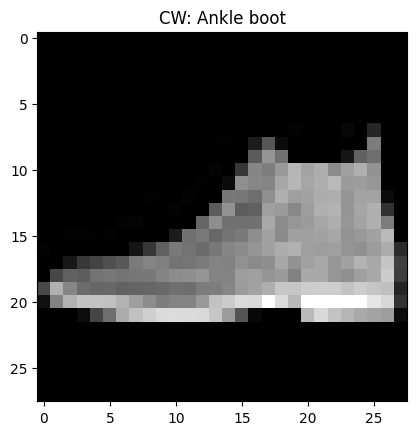

In [7]:
test_key, epsilons = sample_gaussian(test_key, (1, model_config.n_classes * K, model_config.d_latent))
epsilon = epsilons[0]

cw_model = untargeted_WG_Attack(classifier, max_iter=100, learning_rate=0.1, c=1, p=2)
corrupted_x_cw, new_label_cw, perturbation_norm_cw = cw_model.get_perturbation(x, epsilon, all_ys, K)

plt.imshow(corrupted_x_cw.reshape(28, 28), cmap='gray')
plt.title(f"CW: {map_label_to_name(true_label)}")
plt.show()

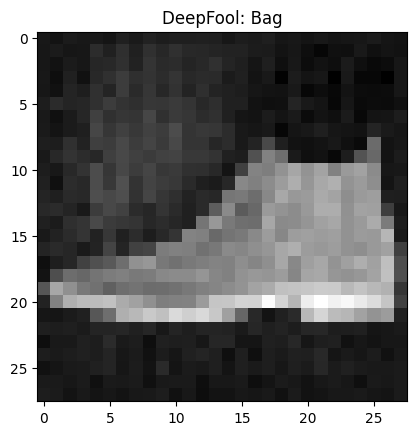

In [8]:
test_key, epsilons = sample_gaussian(test_key, (1, model_config.n_classes * K, model_config.d_latent))
epsilon = epsilons[0]
deepfool_model = DeepFool(config)
corrupted_x_deepfool, new_label_deepfool, perturbation_norm_deepfool = deepfool_model.get_perturbation(x, epsilon, all_ys, K)

plt.imshow(corrupted_x_deepfool.reshape(28, 28), cmap='gray')
plt.title(f"DeepFool: {map_label_to_name(new_label_deepfool)}")
plt.show()

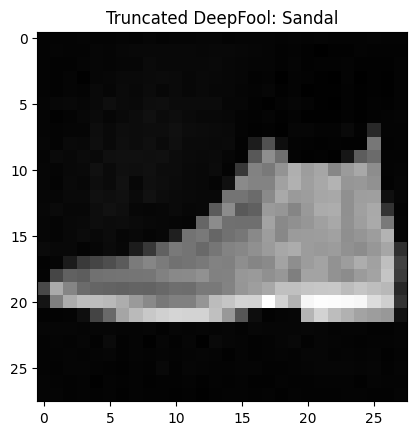

In [9]:
test_key, epsilons = sample_gaussian(test_key, (1, model_config.n_classes * K, model_config.d_latent))
epsilon = epsilons[0]

truncated_deepfool_model = DeepFool(config, learning_rate=0.2)
corrupted_x_truncated, new_label_truncated, perturbation_norm_truncated = truncated_deepfool_model.get_perturbation(x, epsilon, all_ys, K)

plt.imshow(corrupted_x_truncated.reshape(28, 28), cmap='gray')
plt.title(f"Truncated DeepFool: {map_label_to_name(new_label_truncated)}")
plt.show()

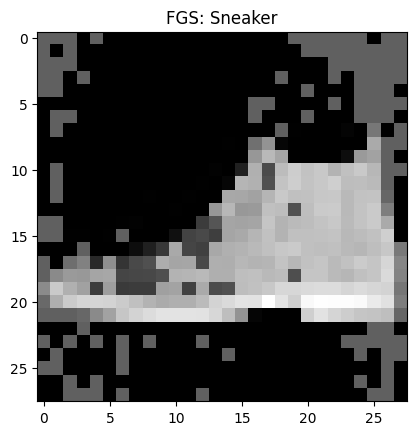

In [10]:
test_key, epsilons = sample_gaussian(test_key, (1, model_config.n_classes * K, model_config.d_latent))
epsilon = epsilons[0]
fgs_model = FastGradientSign(eta=0.3)
corrupted_x_fgs, new_label_fgs, perturbation_norm_fgs = fgs_model.get_perturbation(x, epsilon, all_ys)

plt.imshow(corrupted_x_fgs.reshape(28, 28), cmap='gray')
plt.title(f"FGS: {map_label_to_name(new_label_fgs)}")
plt.show()

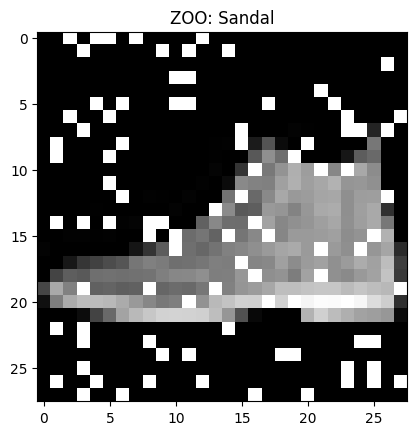

In [17]:
test_key, epsilons = sample_gaussian(test_key, (1, model_config.n_classes * K, model_config.d_latent))
epsilon = epsilons[0]

zoo_model = untargeted_ZOO_Attack(classifier.classifier, step_size = 1, max_iter=100, c=1, p=2)
corrupted_x_zoo, new_label_zoo, perturbation_norm_zoo = zoo_model.get_perturbation(x, epsilon, all_ys, K=1)

plt.imshow(corrupted_x_zoo.reshape(28, 28), cmap='gray')
plt.title(f"ZOO: {map_label_to_name(new_label_zoo)}")
plt.show()

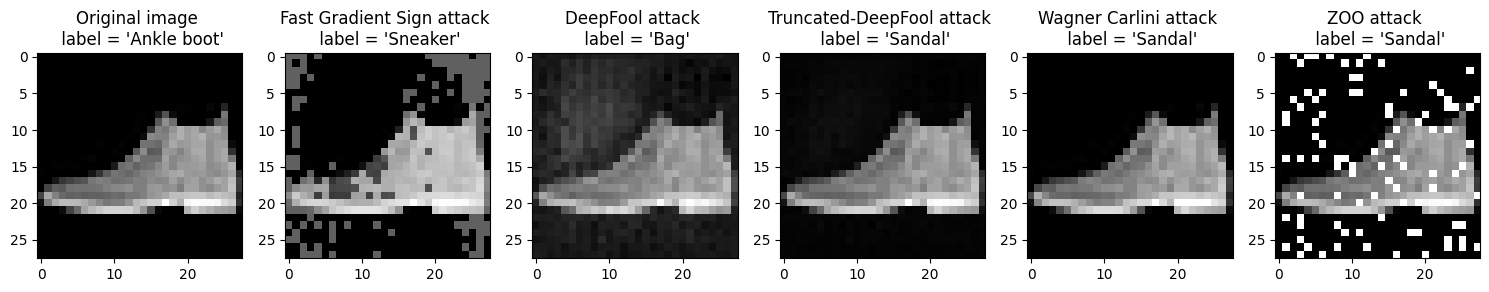

In [19]:
fig, axs = plt.subplots(1, 6, figsize=(15, 5))

axs[0].imshow(x.reshape(28, 28), cmap="gray")
axs[0].set_title(f"Original image \n label = '{map_label_to_name(true_label)}'")

axs[1].imshow(corrupted_x_fgs.reshape(28, 28), cmap="gray")
axs[1].set_title(f"Fast Gradient Sign attack \n label = '{map_label_to_name(new_label_fgs)}'")

axs[2].imshow(corrupted_x_deepfool.reshape(28, 28), cmap="gray")
axs[2].set_title(f"DeepFool attack \n label = '{map_label_to_name(new_label_deepfool)}'")

axs[3].imshow(corrupted_x_truncated.reshape(28, 28), cmap="gray")
axs[3].set_title(f"Truncated-DeepFool attack \n label = '{map_label_to_name(new_label_truncated)}'")

axs[4].imshow(corrupted_x_cw.reshape(28, 28), cmap="gray")
axs[4].set_title(f"Wagner Carlini attack \n label = '{map_label_to_name(new_label_cw)}'")

axs[5].imshow(corrupted_x_zoo.reshape(28, 28), cmap="gray")
axs[5].set_title(f"ZOO attack \n label = '{map_label_to_name(new_label_zoo)}'")

plt.tight_layout()
# plt.savefig(f"../latex/illustrations/attacks_sample_{model_type}.png")
plt.show()